In [1]:
import numpy as np
from numpy import trapz
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
import pymoc
from pymoc.util.catalog import catalog_to_moc
from pymoc.io.fits import read_moc_fits
from scipy.stats import norm,kstest
import xidplus
import glob

from astropy.table import Table,vstack,Column,join,hstack
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky,search_around_sky

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc

In [2]:
fname = 'data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()


imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header

im250=hdulist['image'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['image'].header)
hdulist.close()

imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE350_v1.0.fits'
hdulist = fits.open(pswfits)
im350phdu=hdulist[0].header
im350hdu=hdulist['image'].header

im350=hdulist['image'].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist['image'].header)
hdulist.close()

imfolder='../../../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE500_v1.0.fits'
hdulist = fits.open(pswfits)
im500phdu=hdulist[0].header
im500hdu=hdulist['image'].header

im500=hdulist['image'].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist['image'].header)
hdulist.close()

In [3]:
spire_prior = Table.read('data/data_release/xidplus_prior_cat.fits')
spire_prior[0]

ra,dec,help_id,flag_optnir_det,f_mips_24
deg,deg,,,
float64,float64,bytes1728,float64,float64
239.086706815057,54.8536967354993,HELP_J155620.810+545113.308,7.0,272.37057


In [4]:
lofar_sources = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
lofar_sources[0]

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,flo

In [5]:
lofar_fir = Table.read('data/data_release/XID+_lofar_ELAIS-N1_v0.5.fits')
lofar = join(lofar_sources,lofar_fir,join_type='outer',keys='Source_Name')
print(len(lofar))
lofar[0]

31645


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24_1,FErr_MIPS_24_u_1,FErr_MIPS_24_l_1,Bkg_MIPS_24_1,Sig_conf_MIPS_24_1,Rhat_MIPS_24_1,n_eff_MIPS_24_1,Pval_res_24_1,flag_mips_24,F_PACS_100_1,FErr_PACS_100_u_1,FErr_PACS_100_l_1,F_PACS_160_1,FErr_PACS_160_u_1,FErr_PACS_160_l_1,Bkg_PACS_100_1,Bkg_PACS_160_1,Sig_conf_PACS_100_1,Sig_conf_PACS_160_1,Rhat_PACS_100_1,Rhat_PACS_160_1,n_eff_PACS_100_1,n_eff_PACS_160_1,Pval_res_100_1,Pval_res_160_1,flag_PACS_100_1,flag_PACS_160_1,F_SPIRE_250_1,FErr_SPIRE_250_u_1,FErr_SPIRE_250_l_1,F_SPIRE_350_1,FErr_SPIRE_350_u_1,FErr_SPIRE_350_l_1,F_SPIRE_500_1,FErr_SPIRE_500_u_1,FErr_SPIRE_500_l_1,Bkg_SPIRE_250_1,Bkg_SPIRE_350_1,Bkg_SPIRE_500_1,Sig_conf_SPIRE_250_1,Sig_conf_SPIRE_350_1,Sig_conf_SPIRE_500_1,Rhat_SPIRE_250_1,Rhat_SPIRE_350_1,Rhat_SPIRE_500_1,n_eff_SPIRE_250_1,n_eff_SPIRE_500_1,n_eff_SPIRE_350_1,Pval_res_250_1,Pval_res_350_1,Pval_res_500_1,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,F_MIPS_24_2,FErr_MIPS_24_u_2,FErr_MIPS_24_l_2,Bkg_MIPS_24_2,Sig_conf_MIPS_24_2,Rhat_MIPS_24_2,n_eff_MIPS_24_2,Pval_res_24_2,flag_MIPS_24,XID+_rerun_mips,F_PACS_100_2,FErr_PACS_100_u_2,FErr_PACS_100_l_2,F_PACS_160_2,FErr_PACS_160_u_2,FErr_PACS_160_l_2,Bkg_PACS_100_2,Bkg_PACS_160_2,Sig_conf_PACS_100_2,Sig_conf_PACS_160_2,Rhat_PACS_100_2,Rhat_PACS_160_2,n_eff_PACS_100_2,n_eff_PACS_160_2,Pval_res_100_2,Pval_res_160_2,flag_PACS_100_2,flag_PACS_160_2,XID+_rerun_pacs,F_SPIRE_250_2,FErr_SPIRE_250_u_2,FErr_SPIRE_250_l_2,F_SPIRE_350_2,FErr_SPIRE_350_u_2,FErr_SPIRE_350_l_2,F_SPIRE_500_2,FErr_SPIRE_500_u_2,FErr_SPIRE_500_l_2,Bkg_SPIRE_250_2,Bkg_SPIRE_350_2,Bkg_SPIRE_500_2,Sig_conf_SPIRE_250_2,Sig_conf_SPIRE_350_2,Sig_conf_SPIRE_500_2,R

In [6]:
pybdsf_results = Table.read('data/data_release/pybdsf_source.fits')

ilt = []
if pybdsf_results['RA'].unit == u.deg:
    sc = SkyCoord(pybdsf_results['RA'], pybdsf_results['DEC'], frame='icrs')
else:
    sc = SkyCoord(pybdsf_results['RA']*u.deg,pybdsf_results['DEC']*u.deg,frame='icrs')
strings = sc.to_string(style='hmsdms',sep='',precision=2)
for s in strings:
    ilt.append(str('ILTJ'+s).replace(' ','')[:-1])
pybdsf_results['Source_Name'] = ilt
if 'Maj' not in pybdsf_results.columns:
    # insert dummy
    pybdsf_results['Maj'] = 60
    pybdsf_results['Min'] = 60
    pybdsf_results['PA'] = 0
    
print(len(pybdsf_results))
pybdsf_results[0]

84862


Source_id,Isl_id,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,RA_max,E_RA_max,DEC_max,E_DEC_max,Maj,E_Maj,Min,E_Min,PA,E_PA,Maj_img_plane,E_Maj_img_plane,Min_img_plane,E_Min_img_plane,PA_img_plane,E_PA_img_plane,DC_Maj,E_DC_Maj,DC_Min,E_DC_Min,DC_PA,E_DC_PA,DC_Maj_img_plane,E_DC_Maj_img_plane,DC_Min_img_plane,E_DC_Min_img_plane,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,Source_Name
,,deg,deg,deg,deg,Jy,Jy,Jy / beam,Jy / beam,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,Jy,Jy,Jy / beam,Jy / beam,Jy / beam,Jy / beam,,
int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,str22
0,0,249.66575687926377,0.0003542323167302256,53.19116763095687,0.0005102366534686242,0.00724623704288422,0.002176634275982254,0.0014003181947196443,0.0003567965234569429,249.66575687926377,0.0003542323167302256,53.19116763095687,0.0005102366534686242,0.004627554436349414,0.0012615562930382827,0.003115559293232753,0.0007419426750873781,164.29394674708303,40.729054132850976,0.004627554430255951,0.0012615562930382827,0.0031062168308463355,0.0007419426750873781,158.75836685974207,40.729054132850976,0.004316999221093792,0.0012615562930382827,0.0026291058458212907,0.0007419426750873781,164.29394674708303,40.729054132850976,0.0043169992155667235,0.0012615562930382827,0.002621222085679745,0.0007419426750873781,158.75836685974207,40.729054132850976,0.002741781686807582,0.0005281967717516944,0.00038015074096620083,0.0,0.00041588189196772873,0.00044195129885338247,S,ILTJ163839.78+531128.2


In [62]:
#lingyu_ir_results = Table.read('data/IR_lum_sources_lingyu/lingyu_en1/multi_en1_18_final_overlap.fits')
lingyu_ir_results = Table.read('data/IR_lum_sources_lingyu/lingyu_en1/en1_multi_cigale_re_value_added.txt',format='ascii')
#lingyu_ir_results.rename_column('RA_2','RA')
#lingyu_ir_results.rename_column('id','Source_id')
print(len(lingyu_ir_results))
lingyu_ir_results[0]

1266


Source_id,RA_lofar_b,DEC_lofar_b,Total_flux_1,E_Total_flux_1,GroupID,GroupSize,Separation_1,Source_Name,RA_lofar_f,DEC_lofar_f,Total_flux_2,E_Total_flux_2,Peak_flux,E_Peak_flux,flag_clean,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,g_flux_corr,g_fluxerr_corr,r_flux_corr,r_fluxerr_corr,i_flux_corr,i_fluxerr_corr,z_flux_corr,z_fluxerr_corr,y_flux_corr,y_fluxerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,J_flux_corr,J_fluxerr_corr,K_flux_corr,K_fluxerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,Separation_2,help_id,CLASS_STAR,F_MIPS_24,MIPS1_err,F_PACS_100,herschel.pacs.100_err,F_PACS_160,herschel.pacs.160_err,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,chi_r_best,AGN,optAGN,IRAGN,XrayAGN,Mass_median,Separation,F_SPIRE_250,PSW_err,F_SPIRE_350,PMW_err,F_SPIRE_500,PLW_err,bayes.universe.redshift,bayes.universe.redshift_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,best.chi_square,best.reduced_chi_square,best.agn.agn_luminosity,best.agn.beta,best.agn.fracAGN,best.agn.gamma,best.agn.luminosity,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.scatt_luminosity,best.agn.tau,best.agn.therm_luminosity,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.FUV,best.attenuation.V_B90,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.param.restframe_FUV-NUV,best.param.restframe_Lnu(B_B90),best.param.restframe_Lnu(J_2mass),best.param.restframe_Lnu(Ks_2mass),best.param.restframe_Lnu(V_B90),best.param.restframe_NUV-r_prime,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.lum_old,best.stellar.lum_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.metallicity,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.MCam_u,best.PANSTARRS_g,best.PANSTARRS_r,best.PANSTARRS_i,best.PANSTARRS_z,best.PANSTARRS_y,best.subaru.hsc.g,best.subaru.hsc.r,best.subaru.hsc.i,best.subaru.hsc.z,best.subaru.hsc.y,best.HSC_NB921,best.WFCAM_J,best.WFCAM_K,best.IRAC1,best.IRAC2,best.IRAC3,best.IRAC4,best.spitzer.irac.ch1,best.spitzer.irac.ch2,best.MIPS1,best.herschel.pacs.100,best.herschel.pacs.160,best.PSW,best.PMW,best.PLW,mass_cigale,mass_cigale_err,sfr_cigale,sfr_cigale_err,LIR,LIR_err,L150,L150_WperHz,qirc,L150_err,L150_WperHz_err,qirc_err,z
float64,float64,float64,float64,float64,int64,int64,float64,str22,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str27,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,fl

1266


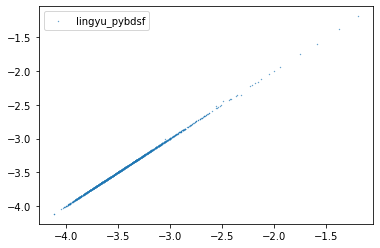

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux_ian,E_Peak_flux_ian,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean_ian,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP_ian,u_flux_corr_ian,u_fluxerr_corr_ian,u_mag_corr,u_magerr_corr,g_flux_corr_ian,g_fluxerr_corr_ian,g_mag_corr,g_magerr_corr,r_flux_corr_ian,r_fluxerr_corr_ian,r_mag_corr,r_magerr_corr,i_flux_corr_ian,i_fluxerr_corr_ian,i_mag_corr,i_magerr_corr,z_flux_corr_ian,z_fluxerr_corr_ian,z_mag_corr,z_magerr_corr,y_flux_corr_ian,y_fluxerr_corr_ian,y_mag_corr,y_magerr_corr,g_hsc_flux_corr_ian,g_hsc_fluxerr_corr_ian,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr_ian,r_hsc_fluxerr_corr_ian,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr_ian,i_hsc_fluxerr_corr_ian,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr_ian,z_hsc_fluxerr_corr_ian,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr_ian,y_hsc_fluxerr_corr_ian,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr_ian,nb921_hsc_fluxerr_corr_ian,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr_ian,J_fluxerr_corr_ian,J_mag_corr,J_magerr_corr,K_flux_corr_ian,K_fluxerr_corr_ian,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr_ian,ch1_swire_fluxerr_corr_ian,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr_ian,ch2_swire_fluxerr_corr_ian,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr_ian,ch3_swire_fluxerr_corr_ian,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr_ian,ch4_swire_fluxerr_corr_ian,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr_ian,ch1_servs_fluxerr_corr_ian,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr_ian,ch2_servs_fluxerr_corr_ian,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation_ian,help_id_ian,RA_HELP,DEC_HELP,EBV,CLASS_STAR_ian,F_MIPS_24_1,FErr_MIPS_24_u_1,FErr_MIPS_24_l_1,Bkg_MIPS_24_1,Sig_conf_MIPS_24_1,Rhat_MIPS_24_1,n_eff_MIPS_24_1,Pval_res_24_1,flag_mips_24,F_PACS_100_1,FErr_PACS_100_u_1,FErr_PACS_100_l_1,F_PACS_160_1,FErr_PACS_160_u_1,FErr_PACS_160_l_1,Bkg_PACS_100_1,Bkg_PACS_160_1,Sig_conf_PACS_100_1,Sig_conf_PACS_160_1,Rhat_PACS_100_1,Rhat_PACS_160_1,n_eff_PACS_100_1,n_eff_PACS_160_1,Pval_res_100_1,Pval_res_160_1,flag_PACS_100_1,flag_PACS_160_1,F_SPIRE_250_1,FErr_SPIRE_250_u_1,FErr_SPIRE_250_l_1,F_SPIRE_350_1,FErr_SPIRE_350_u_1,FErr_SPIRE_350_l_1,F_SPIRE_500_1,FErr_SPIRE_500_u_1,FErr_SPIRE_500_l_1,Bkg_SPIRE_250_1,Bkg_SPIRE_350_1,Bkg_SPIRE_500_1,Sig_conf_SPIRE_250_1,Sig_conf_SPIRE_350_1,Sig_conf_SPIRE_500_1,Rhat_SPIRE_250_1,Rhat_SPIRE_350_1,Rhat_SPIRE_500_1,n_eff_SPIRE_250_1,n_eff_SPIRE_500_1,n_eff_SPIRE_350_1,Pval_res_250_1,Pval_res_350_1,Pval_res_500_1,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST_ian,Z_BEST_SOURCE_ian,Z_SPEC_ian,z1_median_ian,z1_min_ian,z1_max_ian,z1_area_ian,z2_median_ian,z2_min_ian,z2_max_ian,z2_area_ian,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best_ian,chi_r_stellar,stellar_type,AGN_ian,optAGN_ian,IRAGN_ian,XrayAGN_ian,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median_ian,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,F_MIPS_24_2,FErr_MIPS_24_u_2,FErr_MIPS_24_l_2,Bkg_MIPS_24_2,Sig_conf_MIPS_24_2,Rhat_MIPS_24_2,n_eff_MIPS_24_2,Pval_res_24_2,flag_MIPS_24,XID+_rerun_mips,F_PACS_100_2,FErr_PACS_100_u_2,FErr_PACS_100_l_2,F_PACS_160_2,FErr_PACS_160_u_2,FErr_PACS_160_l_2,Bkg_PACS_100_2,Bkg_PACS_160_2,Sig_conf_PACS_100_2,Sig_conf_PACS_160_2,Rhat_PACS_100_2,Rhat_PACS_160_2,n_eff_PACS_100_2,n_eff_PACS_160_2,Pval_res_100_2,Pval_res_160_2,flag_PACS_100_2,flag_PACS_160_2,XID+_rerun_pacs,F_SPIRE_250_

In [63]:
lingyu_lofar = join(lofar,lingyu_ir_results,keys='Source_Name',table_names=['ian','lingyu'])
#print(len(lingyu_lofar))
#lingyu_lofar = join(lingyu_lofar,lofar,keys='Source_Name',table_names=['lingyu','lofar'])
print(len(lingyu_lofar))

x = np.log10(lingyu_lofar['Total_flux'])
y = np.log10(lingyu_lofar['Total_flux_1'])
plt.scatter(x,y,s=0.1,label='lingyu_pybdsf')

plt.legend()
plt.show()

lingyu_lofar[0]

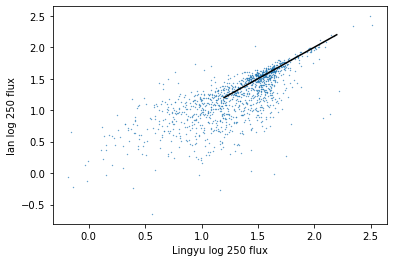

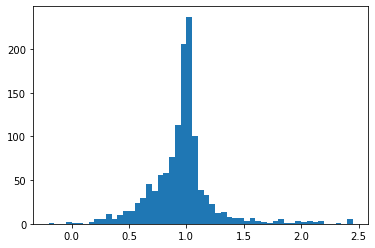

In [69]:
#x = np.log10(lingyu_lofar['F_BLIND_MF_SPIRE_250'])+3
x = np.log10(lingyu_lofar['F_SPIRE_250'])
ian_250 = lingyu_lofar['F_SPIRE_250_1']
mask = np.isnan(ian_250)
ian_250[mask] = lingyu_lofar['F_SPIRE_250_2'][mask]
y = np.log10(ian_250)
plt.scatter(x,y,s=0.1)
plt.plot([1.2,2.2],[1.2,2.2],c='black')
plt.xlabel('Lingyu log 250 flux')
plt.ylabel('Ian log 250 flux')
plt.show()

plt.hist(y/x,bins=np.arange(-0.2,2.5,0.05))
plt.show()

In [15]:
for name in lingyu_lofar.colnames:
    if 'z' in name or 'Z' in name:
        print(name)

LGZ_Size
LGZ_Width
LGZ_PA
Zoom_prob
ID_SPITZER
z_flux_corr_pybdsf
z_fluxerr_corr_pybdsf
z_mag_corr
z_magerr_corr
z_hsc_flux_corr_pybdsf
z_hsc_fluxerr_corr_pybdsf
z_hsc_mag_corr
z_hsc_magerr_corr
Z_BEST_pybdsf
Z_BEST_SOURCE_pybdsf
Z_SPEC_pybdsf
z1_median_pybdsf
z1_min_pybdsf
z1_max_pybdsf
z1_area_pybdsf
z2_median_pybdsf
z2_min_pybdsf
z2_max_pybdsf
z2_area_pybdsf
nfilt_eazy
tot_corr_z
tot_corr_err_z
zmodel
z_rest
GroupSize
z_flux_corr_lingyu
z_fluxerr_corr_lingyu
z_hsc_flux_corr_lingyu
z_hsc_fluxerr_corr_lingyu
Z_BEST_lingyu
Z_BEST_SOURCE_lingyu
Z_SPEC_lingyu
z1_median_lingyu
z1_min_lingyu
z1_max_lingyu
z1_area_lingyu
z2_median_lingyu
z2_min_lingyu
z2_max_lingyu
z2_area_lingyu


1266


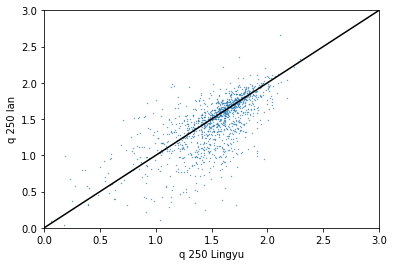

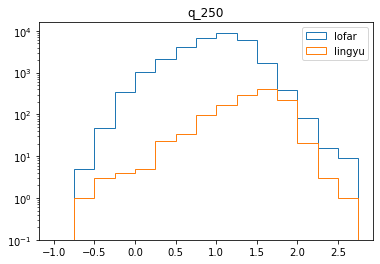

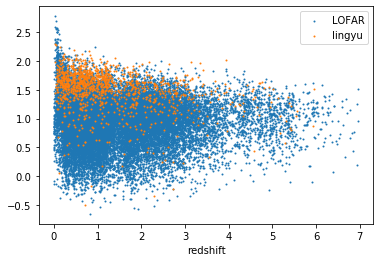

In [77]:
alpha = -0.71

z = lingyu_lofar['Z_BEST_lingyu']
dist = cosmo.luminosity_distance(z).to(u.m).value

radio_flux = lingyu_lofar['Total_flux']*1000
lum_rad = radio_flux*4*np.pi*dist**2 * 1E-26 * (1+z)**(-1-alpha)

ian_250 = lingyu_lofar['F_SPIRE_250_1']
mask = np.isnan(ian_250)
ian_250[mask] = lingyu_lofar['F_SPIRE_250_2'][mask]
lum_ian = ian_250*4*np.pi*dist**2 * 1E-26 * (1+z)**-1
q_ian_c = np.log10(lum_ian/lum_rad)
print(len(q_ian_c))


lingyu_250 = lingyu_lofar['F_SPIRE_250']
lum_lingyu = lingyu_250*4*np.pi*dist**2 * 1E-26 * (1+z)**-1
q_lingyu_c = np.log10(lum_lingyu/lum_rad)

plt.scatter(q_lingyu_c,q_ian_c,s=0.1,label='lingyu')
plt.plot([0,3],[0,3],c='black')
plt.xlim(0,3)
plt.ylim(0,3)
plt.xlabel('q 250 Lingyu')
plt.ylabel('q 250 Ian')
plt.show()

lofar_250 = lofar['F_SPIRE_250_1']
mask = np.isnan(lofar_250)
lofar_250[mask] = lofar['F_SPIRE_250_2'][mask]


radio_flux_lofar = lofar['Total_flux']*1000
z = lofar['Z_BEST']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad_lofar = radio_flux_lofar*4*np.pi*dist**2 * 1E-26 * (1+z)**(-1-alpha)
q_lofar_c = np.log10(lofar_250,lum_rad_lofar)

bins = np.arange(-1,3,0.25)
plt.hist(q_lofar_c,label='lofar',log=True,histtype='step',bins=bins)
plt.hist(q_ian_c,label='lingyu',log=True,histtype='step',bins=bins)
plt.title('q_250')
plt.legend()
plt.show()

plt.scatter(lofar['Z_BEST'],q_lofar_c,s=1,label='LOFAR')
plt.scatter(lingyu_lofar['Z_BEST_lingyu'],q_lingyu_c,s=1,label='lingyu')
plt.xlabel('redshift')
plt.legend()
plt.show()

In [41]:
cigale_input = Table.read('data/cigale_fritz/EN1_sedfit.fits')
col = Column(name='id',data=np.arange(0,len(cigale_input),1))
cigale_input.add_column(col)
print(len(cigale_input))
cigale_input[0]

31645


Source_Name,radioID,ID,z1_median,Z_BEST,newXIDp,FLAG_SERVS,u_f,u_e,u_e_raw,g_f,g_e,g_e_raw,r_f,r_e,r_e_raw,i_f,i_e,i_e_raw,z_f,z_e,z_e_raw,y_f,y_e,y_e_raw,g_hsc_f,g_hsc_e,g_hsc_e_raw,r_hsc_f,r_hsc_e,r_hsc_e_raw,i_hsc_f,i_hsc_e,i_hsc_e_raw,z_hsc_f,z_hsc_e,z_hsc_e_raw,y_hsc_f,y_hsc_e,y_hsc_e_raw,nb921_hsc_f,nb921_hsc_e,nb921_hsc_e_raw,J_f,J_e,J_e_raw,K_f,K_e,K_e_raw,ch1_swire_f,ch1_swire_e,ch1_swire_e_raw,ch2_swire_f,ch2_swire_e,ch2_swire_e_raw,ch3_swire_f,ch3_swire_e,ch3_swire_e_raw,ch4_swire_f,ch4_swire_e,ch4_swire_e_raw,ch1_servs_f,ch1_servs_e,ch1_servs_e_raw,ch2_servs_f,ch2_servs_e,ch2_servs_e_raw,MIPS_24_f,MIPS_24_e,MIPS_24_e_raw,PACS_100_f,PACS_100_e,PACS_100_e_raw,PACS_160_f,PACS_160_e,PACS_160_e_raw,SPIRE_250_f,SPIRE_250_e,SPIRE_250_e_raw,SPIRE_350_f,SPIRE_350_e,SPIRE_350_e_raw,SPIRE_500_f,SPIRE_500_e,SPIRE_500_e_raw,id
,,,,,,,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,
bytes22,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
ILTJ155957.58+550052.4,0,1018637,2.0437,2.0437,0,0,3.0295529019832606e-07,1.1522355377751095e-07,1.111694574356079e-07,9.086021037697791e-07,1.682731370263108e-07,1.4163428544998168e-07,nan,nan,nan,nan,nan,nan,6.435323191881179e-07,2.810875200733856e-07,2.7362173795700073e-07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.168112816619873e-05,1.4744046629501207e-06,8.996563553810119e-07,2.6802586456298825e-05,2.995766077440619e-06,1.3382182121276855e-06,4.85103662071228e-05,5.3382470962399235e-06,2.228076696395874e-06,4.169347462081909e-05,4.8876115285068915e-06,2.550546646118164e-06,5.2400089263916015e-05,1.1620967849172087e-05,1.037252140045166e-05,4.342515859985351e-05,1.1195778190743251e-05,1.0319302558898925e-05,nan,nan,nan,nan,nan,nan,0.0004441495,4.7385261309788086e-05,1.651288e-05,0.018182982,0.017670576,0.017576776,0.045925424,0.028075235,0.027697064,0.016893309,0.008801397531255976,0.008637751999999999,0.013668833,0.007649752759313541,0.0075266425,0.003671343,0.004797436504807592,0.004783368,0


In [47]:
cigale_lofar = Table.read('data/cigale_fritz/lofar_team_test_cigale.fits')
print(len(cigale_lofar))
cigale_lofar = join(cigale_lofar,cigale_input,keys='id')
cigale_lofar.rename_column('id','Source_id')

cigale_lingyu = Table.read('data/IR_lum_sources_lingyu/lingyu_en1/en1_multi_cigale_re_value_added.txt',format='ascii')
print(len(cigale_lingyu))

joined_cigale = join(cigale_lingyu,cigale_lofar,keys='Source_Name')
print(len(joined_cigale))
joined_cigale[0]

30536
1266
1255


Source_id_1,RA_lofar_b,DEC_lofar_b,Total_flux_1,E_Total_flux_1,GroupID,GroupSize,Separation_1,Source_Name,RA_lofar_f,DEC_lofar_f,Total_flux_2,E_Total_flux_2,Peak_flux,E_Peak_flux,flag_clean,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,g_flux_corr,g_fluxerr_corr,r_flux_corr,r_fluxerr_corr,i_flux_corr,i_fluxerr_corr,z_flux_corr,z_fluxerr_corr,y_flux_corr,y_fluxerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,J_flux_corr,J_fluxerr_corr,K_flux_corr,K_fluxerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,Separation_2,help_id,CLASS_STAR,F_MIPS_24,MIPS1_err,F_PACS_100,herschel.pacs.100_err,F_PACS_160,herschel.pacs.160_err,Z_BEST_1,Z_BEST_SOURCE,Z_SPEC,z1_median_1,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,chi_r_best,AGN,optAGN,IRAGN,XrayAGN,Mass_median,Separation,F_SPIRE_250,PSW_err,F_SPIRE_350,PMW_err,F_SPIRE_500,PLW_err,bayes.universe.redshift,bayes.universe.redshift_err,bayes.sfh.sfr100Myrs_1,bayes.sfh.sfr100Myrs_err_1,bayes.stellar.m_star_1,bayes.stellar.m_star_err_1,bayes.dust.luminosity_1,bayes.dust.luminosity_err_1,bayes.agn.fracAGN_1,bayes.agn.fracAGN_err_1,best.chi_square_1,best.reduced_chi_square_1,best.agn.agn_luminosity_1,best.agn.beta_1,best.agn.fracAGN_1,best.agn.gamma_1,best.agn.luminosity_1,best.agn.opening_angle_1,best.agn.psy_1,best.agn.r_ratio_1,best.agn.scatt_luminosity_1,best.agn.tau_1,best.agn.therm_luminosity_1,best.attenuation.Av_BC_1,best.attenuation.BC_to_ISM_factor_1,best.attenuation.FUV_1,best.attenuation.V_B90_1,best.attenuation.slope_BC_1,best.attenuation.slope_ISM_1,best.attenuation.stellar.old_1,best.attenuation.stellar.young_1,best.dust.alpha_1,best.dust.gamma_1,best.dust.luminosity_1,best.dust.mass_1,best.dust.qpah_1,best.dust.umin_1,best.param.restframe_FUV-NUV_1,best.param.restframe_Lnu(B_B90)_1,best.param.restframe_Lnu(J_2mass)_1,best.param.restframe_Lnu(Ks_2mass)_1,best.param.restframe_Lnu(V_B90)_1,best.param.restframe_NUV-r_prime_1,best.sfh.age_1,best.sfh.burst_age_1,best.sfh.f_burst_1,best.sfh.integrated_1,best.sfh.sfr_1,best.sfh.sfr100Myrs_1,best.sfh.sfr10Myrs_1,best.sfh.tau_burst_1,best.sfh.tau_main_1,best.stellar.age_m_star_1,best.stellar.imf_1,best.stellar.lum_1,best.stellar.lum_ly_1,best.stellar.lum_ly_old_1,best.stellar.lum_ly_young_1,best.stellar.lum_old_1,best.stellar.lum_young_1,best.stellar.m_gas_1,best.stellar.m_gas_old_1,best.stellar.m_gas_young_1,best.stellar.m_star_1,best.stellar.m_star_old_1,best.stellar.m_star_young_1,best.stellar.metallicity_1,best.stellar.n_ly_1,best.stellar.n_ly_old_1,best.stellar.n_ly_young_1,best.stellar.old_young_separation_age_1,best.universe.age_1,best.universe.luminosity_distance_1,best.universe.redshift_1,best.MCam_u_1,best.PANSTARRS_g_1,best.PANSTARRS_r_1,best.PANSTARRS_i_1,best.PANSTARRS_z_1,best.PANSTARRS_y_1,best.subaru.hsc.g_1,best.subaru.hsc.r_1,best.subaru.hsc.i_1,best.subaru.hsc.z_1,best.subaru.hsc.y_1,best.HSC_NB921_1,best.WFCAM_J_1,best.WFCAM_K_1,best.IRAC1_1,best.IRAC2_1,best.IRAC3_1,best.IRAC4_1,best.spitzer.irac.ch1_1,best.spitzer.irac.ch2_1,best.MIPS1_1,best.herschel.pacs.100_1,best.herschel.pacs.160_1,best.PSW_1,best.PMW_1,best.PLW_1,mass_cigale,mass_cigale_err,sfr_cigale,sfr_cigale_err,LIR,LIR_err,L150,L150_WperHz,qirc,L150_err,L150_WperHz_err,qirc_err,z,Source_id_2,bayes.sfh.sfr100Myrs_2,bayes.sfh.sfr100Myrs_err_2,bayes.stellar.m_star_2,bayes.stellar.m_star_err_2,bayes.dust.luminosity_2,bayes.dust.luminosity_err_2,bayes.agn.fracAGN_2,bayes.agn.fracAGN_err_2,best.chi_square_2,best.reduced_chi_square_2,best.agn.agn_luminosity_2,best.agn.beta_2,best.agn.fracAGN_2,best.agn.gamma_2,best.agn.luminosity_2,best.agn.opening_angle_2,best.agn.psy_2,best

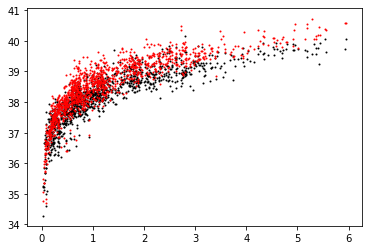

In [82]:
x = joined_cigale['best.universe.redshift_1']
y = np.log10(joined_cigale['bayes.dust.luminosity_1'])
plt.scatter(x,y,s=1,c='black')

x = joined_cigale['best.universe.redshift_1']
y = joined_cigale['bayes.dust.luminosity_1']
y = np.log10(y/joined_cigale['F_SPIRE_250']*45)
plt.scatter(x,y,s=1,c='red')

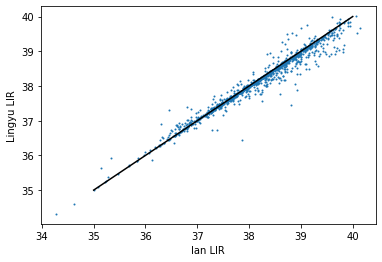

In [56]:
x = np.log10(joined_cigale['bayes.dust.luminosity_1'])
y = np.log10(joined_cigale['bayes.dust.luminosity_2'])
plt.scatter(x,y,s=1)
plt.plot([35,40],[35,40],c='black')
plt.xlabel('Ian LIR')
plt.ylabel('Lingyu LIR')
plt.show()

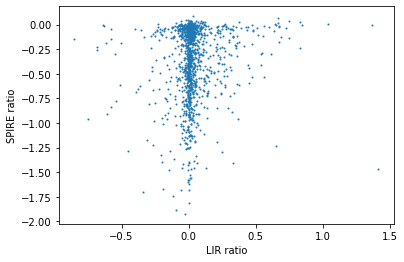

In [58]:
joined_cigale_spire = join(joined_cigale,lingyu_lofar,keys='Source_Name',table_names=['cigale','lingyu'])

lir_ratio = np.log10(joined_cigale_spire['bayes.dust.luminosity_1']/joined_cigale_spire['bayes.dust.luminosity_2'])
spire_ratio = np.log10(joined_cigale_spire['F_SPIRE_250_cigale']/joined_cigale_spire['F_BLIND_MF_SPIRE_250'])-3

plt.scatter(lir_ratio,spire_ratio,s=1)
plt.xlabel('LIR ratio')
plt.ylabel('SPIRE ratio')
plt.show()